In [ ]:
#Imports
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import time
import tracemalloc

In [ ]:
class PINN(nn.Module):
    def __init__(self, layers):
        # The __init__ function initializes the PINN class.
        # Input: layer  array with number of layers, i.e [2,50,50,50,50,2]
        super(PINN, self).__init__()
        self.layers = layers
        self.net = nn.Sequential()
        for i in range(len(layers) - 2):
            self.net.add_module(f'layer_{i}', nn.Linear(layers[i], layers[i+1]))
            self.net.add_module(f'activation_{i}', nn.Tanh())
        self.net.add_module('output', nn.Linear(layers[-2], layers[-1]))

    def forward(self, x, t):
        # The forward function returns the values of the current prediction at the points (x,t).
        # Input:  x   one-dimensional tensor of x-values
        #         t   one-dimensional tensor of t-values (of the same size as x)
        # Output: u   two-dimensional tensor of with the values of the current prediction at the points (x,t)
        X_neu = torch.cat([x, t], dim=1)
        u = self.net(X_neu)
        return u

    def get_div_u(self, x, t):
        # The get_div_u function returns the values returns the values of the predicted solution and its derivatives at the given points (x,t).
        # Input:  x     one-dimensional tensor of x-values
        #         t     one-dimensional tensor of t-values (of the same size as x)
        # Output: u     two-dimensional tensor with the values of the current prediction at the points (x,t)
        #         u_t   one-dimensional tensor with the values of the derivatives of the current prediction for the first function with respect to t at the points (x,t)
        #         u_x   one-dimensional tensor with the values of the derivatives of the current prediction for the first function with respect to x at the points (x,t)
        #         hu_t  one-dimensional tensor with the values of the derivatives of the current prediction for the second function with respect to t at the points (x,t)
        #         hu_x  one-dimensional tensor with the values of the derivatives of the current prediction for the second function with respect to x at the points (x,t)

        u = self.forward(x, t)
        h_t = torch.autograd.grad(u[:,0].reshape(-1, 1), t, grad_outputs=torch.ones_like(u[:,0].reshape(-1, 1)), create_graph=True)[0]
        h_x = torch.autograd.grad(u[:,0].reshape(-1, 1), x, grad_outputs=torch.ones_like(u[:,0].reshape(-1, 1)), create_graph=True)[0]
        hu_t = torch.autograd.grad(u[:,1].reshape(-1, 1), t, grad_outputs=torch.ones_like(u[:,1].reshape(-1, 1)), create_graph=True)[0]
        hu_x = torch.autograd.grad(u[:,1].reshape(-1, 1), x, grad_outputs=torch.ones_like(u[:,1].reshape(-1, 1)), create_graph=True)[0]
        return u, h_x, h_t, hu_x, hu_t

    def loss_complete(self, X, indx_inner, indx_init, indx_bound, loss_initial_1, loss_initial_2, loss_boundary_1, loss_boundary_2, loss_pde_1, loss_pde_2, weight_inner, weight_boundary, b_points, ic_points, in_points):
        # Computes the current loss of the predicted solution.
        # Inputs: X                 two-dimensional tensor of (x,t) points
        #         indx_inner        one-dimensional tensor, index of the points (x,t) in X, which are inside the domain on which the systems of pdes is defined
        #         indx_init         one-dimensional tensor, index of the points (x,t) in X with t=0
        #         indx_bound        one-dimensional tensor, index of the points (x,t) in X, which are on the boundary
        #         loss_initial_1    function of (u, h_x, h_t, hu_x, hu_t, x, t) that compute the loss at the time t=0 (data loss) for first function
        #         loss_initial_2    function of (u, h_x, h_t, hu_x, hu_t, x, t) that compute the loss at the time t=0 (data loss) for second function
        #         loss_boundary_1   function of (u, h_x, h_t, hu_x, hu_t, x, t) that compute the loss at the boundary (data loss) for first function
        #         loss_boundary_2   function of (u, h_x, h_t, hu_x, hu_t, x, t) that compute the loss at the boundary (data loss) for second function
        #         loss_pde_1        function of (u, h_x, h_t, hu_x, hu_t, x, t) that compute the loss of the first pde (physics loss)
        #         loss_pde_2        function of (u, h_x, h_t, hu_x, hu_t, x, t) that compute the loss of the first pde (physics loss)
        #         weight_inner      scalar, factor for the loss of the pde (physics loss)
        #         weight_boundary   scalar, factor for the loss at t=0 and at the boundary (data loss)
        #         b_points          scalar, number of points at the boundary
        #         ic_points         scalar, number of points at t=0
        #         in_points         scalar, number of points, which are inside the domain on which the systems pdes is defined
        # Output:                   scalar, loss of the predicted solution u at the points (x,t)
        x = X[:,0].reshape(-1, 1)
        t = X[:,1].reshape(-1, 1)
        x.requires_grad_(True)
        t.requires_grad_(True)

        u, h_x, h_t, hu_x, hu_t = self.get_div_u(x, t)

        loss_inter_1 = loss_pde_1(u[indx_inner], h_x[indx_inner], h_t[indx_inner], hu_x[indx_inner], hu_t[indx_inner], x[indx_inner], t[indx_inner])
        loss_inter_2 = loss_pde_2(u[indx_inner], h_x[indx_inner], h_t[indx_inner], hu_x[indx_inner], hu_t[indx_inner], x[indx_inner], t[indx_inner])

        loss_init_1 = loss_initial_1(u[indx_init,0].reshape(-1, 1), h_x[indx_init].reshape(-1, 1), h_t[indx_init].reshape(-1, 1), hu_x[indx_init].reshape(-1, 1), hu_t[indx_init].reshape(-1, 1), x[indx_init], t[indx_init])
        loss_init_2 = loss_initial_2(u[indx_init,1].reshape(-1, 1), h_x[indx_init].reshape(-1, 1), h_t[indx_init].reshape(-1, 1), hu_x[indx_init].reshape(-1, 1), hu_t[indx_init].reshape(-1, 1), x[indx_init], t[indx_init])

        loss_bound_1 = loss_boundary_1(u[indx_bound,0].reshape(-1, 1), h_x[indx_bound].reshape(-1, 1), h_t[indx_bound].reshape(-1, 1), hu_x[indx_bound].reshape(-1, 1), hu_t[indx_bound].reshape(-1, 1), x[indx_bound], t[indx_bound])
        loss_bound_2 = loss_boundary_2(u[indx_bound,1].reshape(-1, 1), h_x[indx_bound].reshape(-1, 1), h_t[indx_bound].reshape(-1, 1), hu_x[indx_bound].reshape(-1, 1), hu_t[indx_bound].reshape(-1, 1), x[indx_bound], t[indx_bound])

        loss_1 = weight_inner * (torch.mean(loss_inter_1**2) + torch.mean(loss_inter_2**2)) / in_points
        loss_2 = weight_boundary * ((torch.mean(loss_init_1**2) + torch.mean(loss_init_2**2)) / ic_points + (torch.mean(loss_bound_1**2) + torch.mean(loss_bound_2**2)) / (2 * b_points))

        return loss_1 + loss_2

    def train(self, x_left, x_right, T, initial_points, boundary_points, inner_points, loss_initial_1, loss_initial_2, loss_boundary_1, loss_boundary_2, loss_pde_1, loss_pde_2, weight_inner, weight_boundary, training_time, lrate, fix):
        # Trains the neuronal network.
        # Inputs: x_left            scalar, left boundary of spatial domain
        #         x_right           scalar, right boundary of spatial domain
        #         T                 scalar, time up to which the pde should be solved
        #         initial_points    scalar, number of points at the line t = 0
        #         boundary_points   scalar, number of points at the left/right boundary
        #         inner_points      scalar, number of points at which the physical loss is calculated
        #         loss_initial_1    function of (u, h_x, h_t, hu_x, hu_t, x, t) that compute the loss at the time t=0 (data loss) for first function
        #         loss_initial_2    function of (u, h_x, h_t, hu_x, hu_t, x, t) that compute the loss at the time t=0 (data loss) for second function
        #         loss_boundary_1   function of (u, h_x, h_t, hu_x, hu_t, x, t) that compute the loss at the boundary (data loss) for first function
        #         loss_boundary_2   function of (u, h_x, h_t, hu_x, hu_t, x, t) that compute the loss at the boundary (data loss) for second function
        #         loss_pde_1        function of (u, h_x, h_t, hu_x, hu_t, x, t) that compute the loss of the first pde (physics loss)
        #         loss_pde_2        function of (u, h_x, h_t, hu_x, hu_t, x, t) that compute the loss of the first pde (physics loss)
        #         weight_inner      scalar, factor for the loss of the pde (physics loss)
        #         weight_boundary   scalar, factor for the loss at t=0 and at the boundary (data loss)
        #         training time     scalar, how many trainig iterations are done
        #         lr                scalar, learning rate of the adam optimizer
        #         fix               boolean, if 1 the points at which the data loss is computed are fixed and equidistributed else they are randomly chosen
        # Output: final_losses      array, loss of the predicted solution u at the points (x,t) after the different trainig iterations

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(device)

        indx_bound = torch.arange(0, 2 * boundary_points, step=1).to(device)
        indx_init = torch.arange(2 * boundary_points, initial_points + 2 * boundary_points, step=1).to(device)
        indx_inner = torch.arange(initial_points + 2 * boundary_points, initial_points + 2 * boundary_points + inner_points, step=1).to(device)

        final_losses = []
        optimizer = torch.optim.Adam(self.parameters(), lr=lrate)

        for it in range(training_time):
            x = torch.FloatTensor(inner_points).uniform_(x_left, x_right).reshape(-1, 1).to(device)
            t = torch.FloatTensor(inner_points).uniform_(0, T).reshape(-1, 1).to(device)

            if fix == 1:
                x_0 = torch.linspace(x_left, x_right, initial_points).reshape(-1, 1).to(device)
                t_b = torch.linspace(0, T, boundary_points).reshape(-1, 1).to(device)
            else:
                t_b = torch.FloatTensor(boundary_points).uniform_(0, T).reshape(-1, 1).to(device)
                x_0 = torch.FloatTensor(initial_points).uniform_(x_left, x_right).reshape(-1, 1).to(device)

            x_r = torch.ones_like(t_b) * x_right
            x_l = torch.ones_like(t_b) * x_left
            t_0 = torch.zeros_like(x_0)

            X_bound_right = torch.cat([x_r, t_b], dim=1).to(device)
            X_bound_left = torch.cat([x_l, t_b], dim=1).to(device)
            X_initial = torch.cat([x_0, t_0], dim=1).to(device)
            X_inner = torch.cat([x, t], dim=1).to(device)
            X_full = torch.cat([X_bound_right, X_bound_left, X_initial, X_inner], dim=0).to(device)

            optimizer.zero_grad()
            loss = self.loss_complete(X_full, indx_inner, indx_init, indx_bound, loss_initial_1, loss_initial_2, loss_boundary_1, loss_boundary_2, loss_pde_1, loss_pde_2, weight_inner, weight_boundary, initial_points, boundary_points, inner_points)
            final_losses.append(loss.item())

            if it % 50 == 1:
                print(f"Training iteration: {it}, Loss: {loss.item()}")

            loss.backward()
            optimizer.step()

        with torch.no_grad():
            plt.plot(range(training_time), final_losses)
            plt.ylabel('Loss')
            plt.xlabel('Training Iterations')
            plt.title('Training Loss')
            plt.savefig('loss.pdf')
            plt.savefig('loss.png')

        return final_losses


Finite Volume Method:

In [ ]:
#Numerical Flux
# --------------------------------------------------------------------------
def numericalFlux(Q_L, Q_R):
    #The numericalFlux function computes the numerical flux between the two states Q_L and Q_R by approximately
    #sovling a Riemann problem for the one-dimensional shallow-water equations via the HLL solver. The utilized
    #speed estimates result in the Rusanov flux function.
    #
    #Inputs: Q_L    2x1 vector, initial condition on LEFT boundary, first component is height=h, second component
    #               is height*speed=h*u
    #        Q_R    2x1 vector, initial condition on LEFT boundary, first component is height=h, second component
    #               is height*speed=h*u
    #
    #Output: fluxQ  2x1 vector, \mathcal{F}(Q_L,Q_R)

    #Make sure that inputs are numpy arrays
    Q_L = np.array(Q_L); Q_R = np.array(Q_R)

    #Translating conserved quantities into original values
    h_L = Q_L[0]; u_L = Q_L[1]/Q_L[0]
    h_R = Q_R[0]; u_R = Q_R[1]/Q_R[0]

    #Flux at boundaries
    F_L = np.array([ Q_L[1],  Q_L[1]**2/Q_L[0] + 0.5*9.81*Q_L[0]**2 ])
    F_R = np.array([ Q_R[1],  Q_R[1]**2/Q_R[0] + 0.5*9.81*Q_R[0]**2 ])

    #Maximum wave speed
    lambda_Max = max( abs(u_L) + np.sqrt(9.81*h_L), abs(u_R) + np.sqrt(9.81*h_R) )

    #Rusanov flux
    fluxQ = 0.5*(F_R+F_L) - 0.5*lambda_Max*(Q_R-Q_L)

    return fluxQ

In [ ]:
#Finite-volume method
# --------------------------------------------------------------------------
def sweSolver(A, B, Q_initial, T, C_courant):
    #The sweSolver function computes an approximate solution to the homogenous one-dimensional
    #shallow-water equations on the intervall [A,B] with the initial data Q_initial after time T.
    #The solver utilizes outflow boundary conditions and a time step chosen in accordance with
    #the Courant number C_courant.
    #
    #Inputs: A          scalar, left boundary of spatial domain
    #        B          scalar, right boundary of spatial domain
    #        Q_initial  2xN matrix, where N is the choosen number of discretization points;
    #                   first row corresponds to heights=h, second row corresponds to
    #                   height*speed=h*u
    #        T          scalar, time after which solution is computed
    #        C_courant  scalar between 0 and 1, needed to choose the size of the time step
    #
    #Output: Q          2xN matrix, approximate solution to the conservation law after time T

    #Computing spacial step size dx=$\Delta x$
    N  = Q_initial.shape[1]
    dx = (B-A)/(N-1)

    #Adding ghost cells in spacial domain and initial data
    x = np.linspace(A, B, N)
    x = np.append(A-dx, np.append(x, B+dx ) )
    Q = np.c_[ Q_initial[:,0], Q_initial, Q_initial[:,N-1] ]

    #Euler method
    t = 0
    while t < T:
        #Output the current time to console
        #print(t)

        #Computing maximal wave speed over all cells
        lambda_Max = 0;
        for i in range(1,N):
            #Choosing indices
            L = i-1; R = i
            #Converting from conserved variables to original variables
            h_L = Q[0,L]; u_L = Q[1,L]/Q[0,L]
            h_R = Q[0,R]; u_R = Q[1,R]/Q[0,R]
            #Update wave speed if necessary
            lambda_Max = max( lambda_Max, max( abs(u_L) + np.sqrt(9.81*h_L), abs(u_R) + np.sqrt(9.81*h_R) ) )

        #Compute time step dt=$\Delta t$. In case t+dt>T, we choose the step such that the iteration terminates
        #at the final time T instead
        dt = min( T-t, C_courant*dx/lambda_Max )

        #One time iteration. Q_new is needed to prevent overwriting Q
        Q_new = Q.copy()
        for i in range(1,N):
            Q_new[:,i] = Q[:,i] - dt/dx*( numericalFlux(Q[:,i], Q[:,i+1]) - numericalFlux(Q[:,i-1], Q[:,i]) )

        Q = Q_new

        t = t + dt

    #Remove the ghost cells from the computed solution
    return Q[:,1:-1]

In [ ]:
def dambreak(x):
  indx_1 = torch.where(x<1)[0]
  indx_2 = torch.where(x>=1)[0]
  y = torch.ones_like(x[indx_1])*1.5
  z = torch.ones_like(x[indx_2])*0.5
  return torch.cat((y,z))

def loss_pde1(u, h_x, h_t, hu_x, hu_t,x,t):
  return h_t + hu_x

def loss_pde2(u, h_x, h_t, hu_x, hu_t,x,t):
  return hu_t + 2*(u[:,1].reshape(-1, 1)/u[:,0].reshape(-1, 1))*hu_x + (9.81*u[:,0].reshape(-1, 1) + (u[:,1].reshape(-1, 1)/u[:,0].reshape(-1, 1))**2)*h_x

def initial_1(u, h_x, h_t, hu_x, hu_t,x,t):
  return u-dambreak(x)

def initial_2(u, h_x, h_t, hu_x, hu_t,x,t):
  return u

def boundary_1(u, h_x, h_t, hu_x, hu_t,x,t):
  ind_l = torch.where(x==0)[0]
  ind_r = torch.where(x==2)[0]
  b = torch.ones_like(u)
  b[ind_l]=b[ind_l]*1.5
  b[ind_r]=b[ind_r]*0.5
  return u-b

def boundary_2(u, h_x, h_t, hu_x, hu_t,x,t):
  return u

Training iteration: 1, Loss: 0.001810568617656827
Training iteration: 51, Loss: 0.0005935454391874373
Training iteration: 101, Loss: 0.00037509234971366823
Training iteration: 151, Loss: 0.0003750022151507437
Training iteration: 201, Loss: 0.000375000003259629
Training iteration: 251, Loss: 0.000375000003259629
Training iteration: 301, Loss: 0.000375000003259629
Training iteration: 351, Loss: 0.000375000003259629
Training iteration: 401, Loss: 0.000375000003259629
Training iteration: 451, Loss: 0.000375000003259629
Training iteration: 501, Loss: 0.000375000003259629
Training iteration: 551, Loss: 0.000375000003259629
Training iteration: 601, Loss: 0.000375000003259629
Training iteration: 651, Loss: 0.000375000003259629
Training iteration: 701, Loss: 0.000375000003259629
Training iteration: 751, Loss: 0.000375000003259629
Training iteration: 801, Loss: 0.0003750018950086087
Training iteration: 851, Loss: 0.000375000003259629
Training iteration: 901, Loss: 0.000375000003259629
Training i

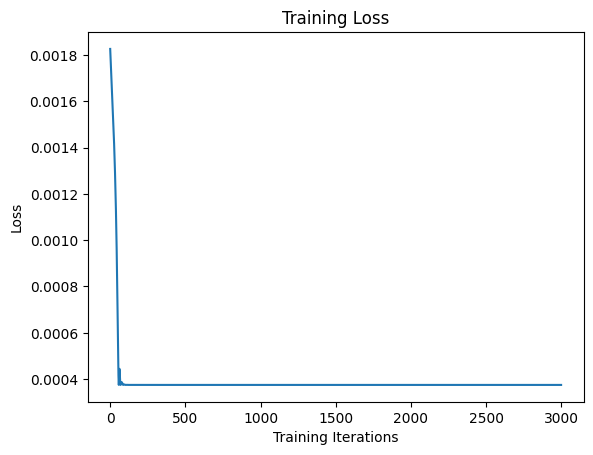

In [ ]:
neunet_1 = PINN([2, 100, 100, 100, 100, 100, 100, 100, 2])

tracemalloc.start()

tic = time.time()

neunet_1.train(0, 2, 0.2, 1000, 1000, 20000, initial_1, initial_2, boundary_1, boundary_2, loss_pde1, loss_pde2, 1, 1, 3000, 0.005,1)

toc = time.time() - tic

print('Used memory (current, max):')
print(tracemalloc.get_traced_memory())
tracemalloc.stop()
print('Time in seconds:')
print(toc)

In [ ]:
tracemalloc.start()

tic = time.time()

x_ex = np.linspace(0,2,200)
q_i = np.array([
    np.where(x_ex<1, 1.5, 0.5) ,
    np.zeros(x_ex.shape)
])
Q_1 = sweSolver(0,2,q_i,0,0.9)
Q_2 = sweSolver(0,2,q_i,0.06,0.9)
Q_3 = sweSolver(0,2,q_i,0.13,0.9)
Q_4 = sweSolver(0,2,q_i,0.2,0.9)


toc = time.time() - tic

print('Used memory (current, max):')
print(tracemalloc.get_traced_memory())
tracemalloc.stop()
print('Time in seconds:')
print(toc)

Used memory (current, max):
(41471, 115175)
Time in seconds:
4.55861759185791


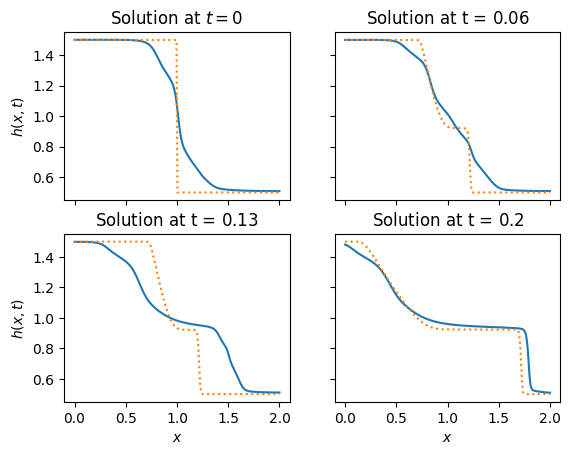

In [ ]:
x = torch.linspace(0,2,200).reshape(-1, 1)
x.requires_grad_(True)

fig, axs = plt.subplots(2, 2,sharey=True)
t = torch.ones_like(x)*0
t.reshape(-1, 1)
t.requires_grad_(True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
u, u_t, u_x, h_t, h_x = neunet_1.get_div_u(x.to(device), t.to(device))
x = x.cpu()
u = u.cpu()
axs[0, 0].plot(x.detach().numpy(), u[:,0].detach().numpy())
axs[0, 0].plot(x_ex, Q_1[0,:], ':')
axs[0, 0].set_title('Solution at $t = 0$')

t = torch.ones_like(x)*0.06
t.reshape(-1, 1)
t.requires_grad_(True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
u, u_t, u_x, h_t, h_x = neunet_1.get_div_u(x.to(device), t.to(device))
x = x.cpu()
u = u.cpu()
axs[0, 1].plot(x.detach().numpy(), u[:,0].detach().numpy())
axs[0, 1].plot(x_ex, Q_2[0,:], ':')
axs[0, 1].set_title('Solution at t = $0.06$')

t = torch.ones_like(x)*0.13
t.reshape(-1, 1)
t.requires_grad_(True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
u, u_t, u_x, h_t, h_x = neunet_1.get_div_u(x.to(device), t.to(device))
x = x.cpu()
u = u.cpu()
axs[1, 0].plot(x.detach().numpy(), u[:,0].detach().numpy())
axs[1, 0].plot(x_ex, Q_2[0,:], ':')
axs[1, 0].set_title('Solution at t = $0.13$')
t = torch.ones_like(x)*0.2
t.reshape(-1, 1)
t.requires_grad_(True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
u, u_t, u_x, h_t, h_x = neunet_1.get_div_u(x.to(device), t.to(device))
x = x.cpu()
u = u.cpu()
axs[1, 1].plot(x.detach().numpy(), u[:,0].detach().numpy())
axs[1, 1].plot(x_ex, Q_4[0,:], ':')
axs[1, 1].set_title('Solution at t = $0.2$')


for ax in axs.flat:
    ax.set(xlabel='$x$', ylabel='$h(x,t)$')

for ax in axs.flat:
    ax.label_outer()

plt.savefig('Sw_5.pdf')
plt.savefig('Sw_5.png')

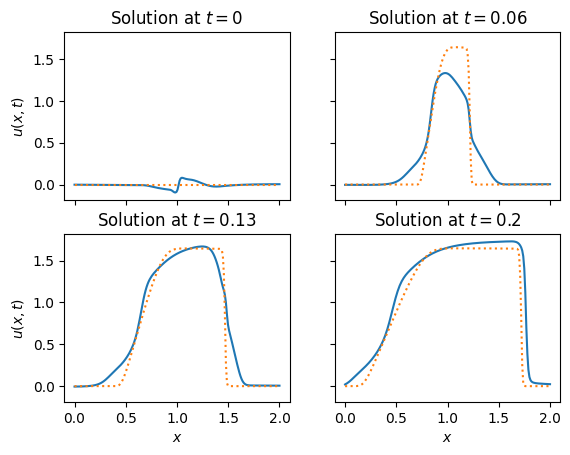

In [ ]:
x = torch.linspace(0,2,200).reshape(-1, 1)
x.requires_grad_(True)

fig, axs = plt.subplots(2, 2,sharey=True)
t = torch.ones_like(x)*0
t.reshape(-1, 1)
t.requires_grad_(True)
u, u_t, u_x, h_t, h_x = neunet_1.get_div_u(x.to('cuda'), t.to('cuda'))
u = u.cpu()
x = x.cpu()
u_plot = u[:,1].detach().numpy()/u[:,0].detach().numpy()
axs[0, 0].plot(x.detach().numpy(), u_plot)
axs[0, 0].plot(x_ex, Q_1[1,:]/Q_1[0,:], ':')
axs[0, 0].set_title('Solution at $t = 0$')

t = torch.ones_like(x)*0.06
t.reshape(-1, 1)
t.requires_grad_(True)
u, u_t, u_x, h_t, h_x = neunet_1.get_div_u(x.to('cuda'), t.to('cuda'))
u = u.cpu()
x = x.cpu()
u_plot = u[:,1].detach().numpy()/u[:,0].detach().numpy()
axs[0, 1].plot(x.detach().numpy(), u_plot)
axs[0, 1].plot(x_ex, Q_2[1,:]/Q_2[0,:], ':')
axs[0, 1].set_title('Solution at $t = 0.06$')

t = torch.ones_like(x)*0.13
t.reshape(-1, 1)
t.requires_grad_(True)
u, u_t, u_x, h_t, h_x = neunet_1.get_div_u(x.to('cuda'), t.to('cuda'))
u = u.cpu()
x = x.cpu()
u_plot = u[:,1].detach().numpy()/u[:,0].detach().numpy()
axs[1, 0].plot(x.detach().numpy(), u_plot)
axs[1, 0].plot(x_ex, Q_3[1,:]/Q_3[0,:], ':')
axs[1, 0].set_title('Solution at $t = 0.13$')

t = torch.ones_like(x)*0.2
t.reshape(-1, 1)
t.requires_grad_(True)
u, u_t, u_x, h_t, h_x = neunet_1.get_div_u(x.to('cuda'), t.to('cuda'))
u = u.cpu()
x = x.cpu()
u_plot = u[:,1].detach().numpy()/u[:,0].detach().numpy()
axs[1, 1].plot(x.detach().numpy(), u_plot)
axs[1, 1].plot(x_ex, Q_4[1,:]/Q_4[0,:], ':')
axs[1, 1].set_title('Solution at $t = 0.2$')


for ax in axs.flat:
    ax.set(xlabel='$x$', ylabel='$u(x,t)$')

for ax in axs.flat:
    ax.label_outer()

plt.savefig('Sw_6.pdf')
plt.savefig('Sw_6.png')

Training iteration: 1, Loss: 0.06142354756593704
Training iteration: 51, Loss: 0.4942583441734314
Training iteration: 101, Loss: 0.49652373790740967
Training iteration: 151, Loss: 0.4965002238750458
Training iteration: 201, Loss: 0.49645233154296875
Training iteration: 251, Loss: 0.4963996112346649
Training iteration: 301, Loss: 0.4963375926017761
Training iteration: 351, Loss: 0.496271014213562
Training iteration: 401, Loss: 0.4961998760700226
Training iteration: 451, Loss: 0.4961213171482086
Training iteration: 501, Loss: 0.4960388243198395
Training iteration: 551, Loss: 0.4959491789340973
Training iteration: 601, Loss: 0.49585679173469543
Training iteration: 651, Loss: 0.49575868248939514
Training iteration: 701, Loss: 0.495655357837677
Training iteration: 751, Loss: 0.4955486059188843
Training iteration: 801, Loss: 0.49543508887290955
Training iteration: 851, Loss: 0.49531662464141846
Training iteration: 901, Loss: 0.4951934814453125
Training iteration: 951, Loss: 0.495066314935684

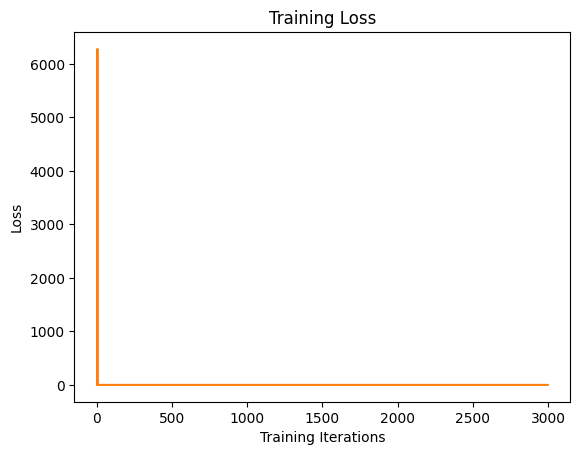

In [ ]:
neunet_2 = PINN([2, 100, 100, 100, 100, 100, 2])
neunet_2.train(0, 2, 0.2, 100, 100, 1000, initial_1, initial_2, boundary_1, boundary_2, loss_pde1, loss_pde2, 1, 1, 1, 0.01,1)

tracemalloc.start()

tic = time.time()

neunet_2.train(0, 2, 0.2, 100, 100, 1000, initial_1, initial_2, boundary_1, boundary_2, loss_pde1, loss_pde2, 1, 1, 3000, 0.01,1)

toc = time.time() - tic

print('Used memory (current, max):')
print(tracemalloc.get_traced_memory())
tracemalloc.stop()
print('Time in seconds:')
print(toc)

In [ ]:
tracemalloc.start()

tic = time.time()

x_ex = np.linspace(0,2,200)
q_i = np.array([
    np.where(x_ex<1, 1.5, 0.5) ,
    np.zeros(x_ex.shape)
])
Q_1 = sweSolver(0,2,q_i,0,0.9)
Q_2 = sweSolver(0,2,q_i,0.06,0.9)
Q_3 = sweSolver(0,2,q_i,0.13,0.9)
Q_4 = sweSolver(0,2,q_i,0.2,0.9)


toc = time.time() - tic

print('Used memory (current, max):')
print(tracemalloc.get_traced_memory())
tracemalloc.stop()
print('Time in seconds:')
print(toc)

Used memory (current, max):
(59284, 113885)
Time in seconds:
6.623344659805298


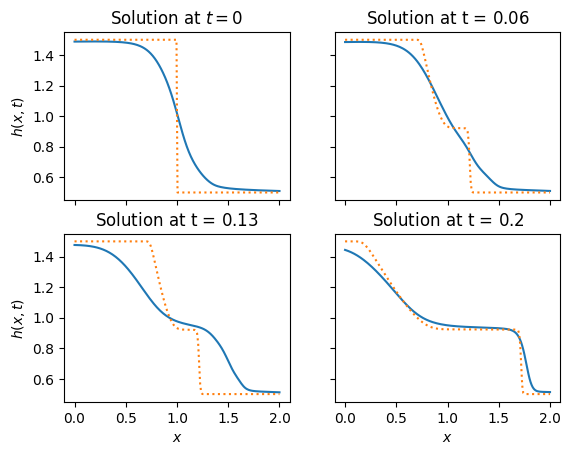

In [ ]:
x = torch.linspace(0,2,200).reshape(-1, 1)
x.requires_grad_(True)

fig, axs = plt.subplots(2, 2,sharey=True)
t = torch.ones_like(x)*0
t.reshape(-1, 1)
t.requires_grad_(True)
u, u_t, u_x, h_t, h_x = neunet_2.get_div_u(x, t)
axs[0, 0].plot(x.detach().numpy(), u[:,0].detach().numpy())
axs[0, 0].plot(x_ex, Q_1[0,:], ':')
axs[0, 0].set_title('Solution at $t = 0$')

t = torch.ones_like(x)*0.06
t.reshape(-1, 1)
t.requires_grad_(True)
u, u_t, u_x, h_t, h_x= neunet_2.get_div_u(x, t)
axs[0, 1].plot(x.detach().numpy(), u[:,0].detach().numpy())
axs[0, 1].plot(x_ex, Q_2[0,:], ':')
axs[0, 1].set_title('Solution at t = $0.06$')

t = torch.ones_like(x)*0.13
t.reshape(-1, 1)
t.requires_grad_(True)
u, u_t, u_x, h_t, h_x = neunet_2.get_div_u(x, t)
axs[1, 0].plot(x.detach().numpy(), u[:,0].detach().numpy())
axs[1, 0].plot(x_ex, Q_2[0,:], ':')
axs[1, 0].set_title('Solution at t = $0.13$')
t = torch.ones_like(x)*0.2
t.reshape(-1, 1)
t.requires_grad_(True)
u, u_t, u_x, h_t, h_x = neunet_2.get_div_u(x, t)
axs[1, 1].plot(x.detach().numpy(), u[:,0].detach().numpy())
axs[1, 1].plot(x_ex, Q_4[0,:], ':')
axs[1, 1].set_title('Solution at t = $0.2$')


for ax in axs.flat:
    ax.set(xlabel='$x$', ylabel='$h(x,t)$')

for ax in axs.flat:
    ax.label_outer()

plt.savefig('Sw_3.pdf')

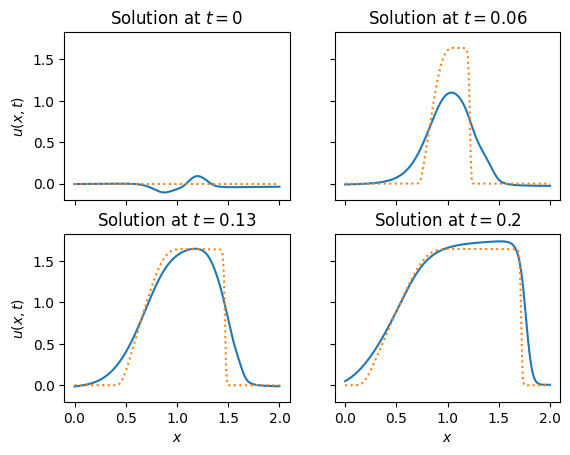

In [ ]:
x = torch.linspace(0,2,200).reshape(-1, 1)
x.requires_grad_(True)

fig, axs = plt.subplots(2, 2,sharey=True)
t = torch.ones_like(x)*0
t.reshape(-1, 1)
t.requires_grad_(True)
u, u_t, u_x, h_t, h_x = neunet_2.get_div_u(x, t)
u_plot = u[:,1].detach().numpy()/u[:,0].detach().numpy()
axs[0, 0].plot(x.detach().numpy(), u_plot)
axs[0, 0].plot(x_ex, Q_1[1,:]/Q_1[0,:], ':')
axs[0, 0].set_title('Solution at $t = 0$')

t = torch.ones_like(x)*0.06
t.reshape(-1, 1)
t.requires_grad_(True)
u, u_t, u_x, h_t, h_x= neunet_2.get_div_u(x, t)
u_plot = u[:,1].detach().numpy()/u[:,0].detach().numpy()
axs[0, 1].plot(x.detach().numpy(), u_plot)
axs[0, 1].plot(x_ex, Q_2[1,:]/Q_2[0,:], ':')
axs[0, 1].set_title('Solution at $t = 0.06$')

t = torch.ones_like(x)*0.13
t.reshape(-1, 1)
t.requires_grad_(True)
u, u_t, u_x, h_t, h_x = neunet_2.get_div_u(x, t)
u_plot = u[:,1].detach().numpy()/u[:,0].detach().numpy()
axs[1, 0].plot(x.detach().numpy(), u_plot)
axs[1, 0].plot(x_ex, Q_3[1,:]/Q_3[0,:], ':')
axs[1, 0].set_title('Solution at $t = 0.13$')

t = torch.ones_like(x)*0.2
t.reshape(-1, 1)
t.requires_grad_(True)
u, u_t, u_x, h_t, h_x = neunet_2.get_div_u(x, t)
u_plot = u[:,1].detach().numpy()/u[:,0].detach().numpy()
axs[1, 1].plot(x.detach().numpy(), u_plot)
axs[1, 1].plot(x_ex, Q_4[1,:]/Q_4[0,:], ':')
axs[1, 1].set_title('Solution at $t = 0.2$')


for ax in axs.flat:
    ax.set(xlabel='$x$', ylabel='$u(x,t)$')

for ax in axs.flat:
    ax.label_outer()

plt.savefig('Sw_4.pdf')